Explore different customisations and test on images that had low resolution when reprojecting.

In [52]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import xarray as xr

from scipy.interpolate import griddata

# for reasonably clean early exit from cells - use exit()
import sys
sys.path.append("..")
from ipython_exit import exit

# Import the library EUMDAC
import eumdac
import time
import requests
import fnmatch
import shutil

from IPython.core.display import HTML
import datetime

# Authentication

In [53]:
# Insert your personal key and secret into the single quotes
# https://api.eumetsat.int/api-key/

consumer_key = 'JSXRnY1_XgcYeOox8PjKozflwrMa'
consumer_secret = 'fbKReD9xf6vh7iE9R5lVVtBID0Ua'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

try:
    print(f"This token '{token}' expires {token.expiration}")
except requests.exceptions.HTTPError as exc:
    print(f"Error when trying the request to the server: '{exc}'")

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/metop/"

This token 'c63e7eae-5ff7-3644-a1bb-4a3459c0af7b' expires 2023-10-23 10:42:35.782257


# Examples of low-resolution images collocated with Irminger 6

In [3]:
with open('in_situ_obs_ascat_with_customisations.pickle', 'rb') as handle: 
    ascat_dict = pickle.load(handle)    

In [4]:
ascat_lon = ascat_dict['Irminger_6']['lon'][0]
ascat_lat = ascat_dict['Irminger_6']['lat'][0]
print(ascat_lon)
print(ascat_lat)

-39.47378
59.9337


In [36]:
products = ascat_dict['Irminger_6']['products']
products

<class 'eumdac.collection.SearchResults'>(EO:EUM:DAT:METOP:ASCSZR1B, {'publication': None, 'dtstart': '2019-08-11T00:10:59.996491+00:00', 'set': None, 'bbox': None, 'orbit': None, 'type': None, 'sat': None, 'sort': None, 'title': None, 't6': None, 'geo': 'POINT(-39.4738 59.9337)', 'dtend': '2020-01-22T09:11:00.009255+00:00', 'zone': None})

In [5]:
dict_low_res = {}
dict_expected_res = {}
count_low = 0
count_high = 0
for key, ascat_fn in ascat_dict['Irminger_6']['nc_files'].items():
    data_ascat = xr.open_dataset(data_dir + ascat_fn)
    if data_ascat.lat[0] - data_ascat.lat[1] > 2:
        dict_low_res[key] = ascat_fn
        print(key, ascat_fn)
        count_low = count_low + 1
    else:
        dict_expected_res[key] = ascat_fn
        #print(ascat_fn)
        count_high = count_high + 1
print(count_low)
print(count_high)

ASCA_SZR_1B_M03_20200121221800Z_20200122000258Z_N_O_20200122000039Z ASCATL1SZR_20200121T221800Z_20200122T000258Z_epct_dde0d061_P.nc
ASCA_SZR_1B_M02_20200121214800Z_20200121232958Z_N_O_20200121233009Z ASCATL1SZR_20200121T214800Z_20200121T232958Z_epct_f73691bd_P.nc
ASCA_SZR_1B_M03_20200120224200Z_20200121002358Z_N_O_20200121002312Z ASCATL1SZR_20200120T224200Z_20200121T002358Z_epct_ecdb2691_P.nc
ASCA_SZR_1B_M01_20200119220300Z_20200119234758Z_N_O_20200119225243Z ASCATL1SZR_20200119T220300Z_20200119T234758Z_epct_e8dea66a_P.nc
ASCA_SZR_1B_M01_20200118222400Z_20200119000858Z_N_O_20200118231342Z ASCATL1SZR_20200118T222400Z_20200119T000858Z_epct_dd7cfae2_P.nc
ASCA_SZR_1B_M03_20200117220300Z_20200117234458Z_N_O_20200117234419Z ASCATL1SZR_20200117T220300Z_20200117T234458Z_epct_42e14e13_P.nc
ASCA_SZR_1B_M02_20200117213000Z_20200117231158Z_N_O_20200117231220Z ASCATL1SZR_20200117T213000Z_20200117T231158Z_epct_5ed3fa55_P.nc
ASCA_SZR_1B_M03_20200116222400Z_20200117000558Z_N_O_20200117000541Z ASCATL1S

# Explore different customisations using the data tailor

In [16]:
datatailor = eumdac.DataTailor(token)

## a) projection='geographic'

Get image with low resolution

In [17]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic'
)

In [42]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 064a2d46 started.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is running.
Customisation 064a2d46 is successfully completed.
All customisations completed!


In [43]:
customisations

[<class 'eumdac.customisation.Customisation'>(064a2d46)]

### Download

In [44]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 064a2d46
Dowloaded the output of the customisation 064a2d46
	Finished dowloading the NetCDF output and deleted the customisation 064a2d46


In [45]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 83, lon: 167)
Coordinates:
  * lat                  (lat) float64 88.1 85.96 83.81 ... -83.68 -85.83 -87.98
  * lon                  (lon) float64 -178.9 -176.7 -174.6 ... 175.4 177.6
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T221800Z
    stop_sensing_time:         20200122T000258.125000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  null
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

## b) projection='geographic', resample_resolution=[0.2, 0.2]

Works, but we do not get the original image

In [92]:
ascat_lat + 10

69.9337

In [93]:
ascat_lat -10

49.9337

In [94]:
ascat_lon + 10

-29.473779999999998

In [95]:
ascat_lon - 10

-49.47378

In [111]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic',
     resample_resolution=[0.2, 0.2]#,
     #filter={"bands" : ["sigma0_trip_fore"]},
     #roi={"NSWE" : [ascat_lat + 10, ascat_lat -10, ascat_lon - 10, ascat_lon + 10]}
)

In [112]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 3730bafc started.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.
Customisation 3730bafc is running.


In [113]:
customisations

[<class 'eumdac.customisation.Customisation'>(3730bafc)]

### Download

In [114]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_resample_resolution_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 3730bafc
Dowloaded the output of the customisation 3730bafc
	Finished dowloading the NetCDF output and deleted the customisation 3730bafc


In [115]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_resample_resolution_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 891, lon: 1793)
Coordinates:
  * lat                  (lat) float64 89.08 88.88 88.68 ... -88.72 -88.92
  * lon                  (lon) float64 -179.9 -179.7 -179.5 ... 178.3 178.5
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T221800Z
    stop_sensing_time:         20200122T000258.125000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  null
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

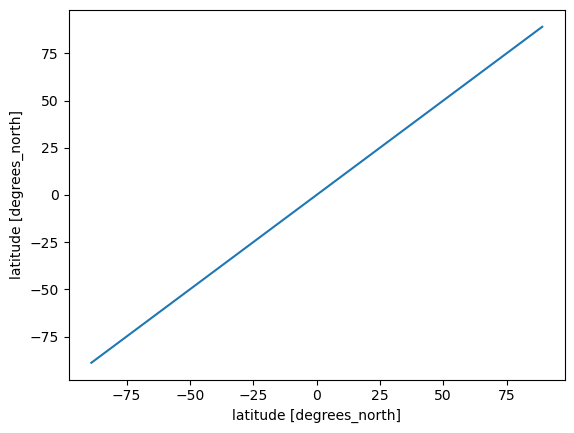

In [117]:
data.lat.plot()

In [118]:
data.lat[1] - data.lat[0]

<xarray.DataArray 'lat' ()>
array(-0.2)

In [119]:
data.lat[101] - data.lat[100]

<xarray.DataArray 'lat' ()>
array(-0.2)

## c) projection='geographic', roi={"NSWE" : [ascat_lat + 10, ascat_lat -10, ascat_lon - 10, ascat_lon + 10]}

Works, but how big can the image be?

In [132]:
ascat_lat + 10

69.9337

In [133]:
ascat_lat -10

49.9337

In [134]:
ascat_lon + 10

-29.473779999999998

In [135]:
ascat_lon - 10

-49.47378

In [136]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic',
     #resample_resolution=[0.2, 0.2]#,
     #filter={"bands" : ["sigma0_trip_fore"]},
     roi={"NSWE" : [ascat_lat + 10, ascat_lat -10, ascat_lon - 10, ascat_lon + 10]}
)

In [137]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 02439558 started.
Customisation 02439558 is running.
Customisation 02439558 is successfully completed.
All customisations completed!


In [138]:
customisations

[<class 'eumdac.customisation.Customisation'>(02439558)]

### Download

In [139]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_roi_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 02439558
Dowloaded the output of the customisation 02439558
	Finished dowloading the NetCDF output and deleted the customisation 02439558


In [141]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_roi_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 135, lon: 135)
Coordinates:
  * lat                  (lat) float64 69.86 69.71 69.56 ... 50.3 50.16 50.01
  * lon                  (lon) float64 -49.4 -49.25 -49.1 ... -29.7 -29.55
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T234748.750000Z
    stop_sensing_time:         20200121T235346.875000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  custom
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

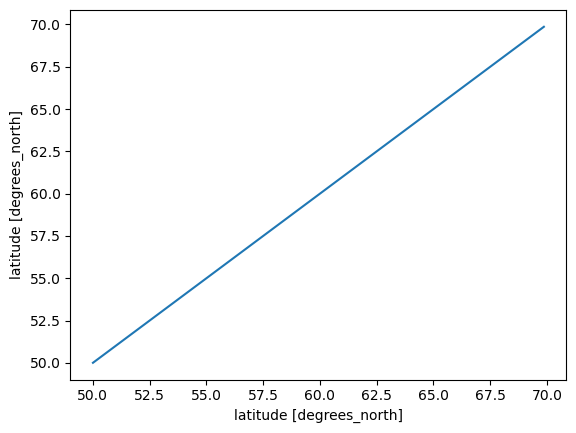

In [142]:
data.lat.plot()

In [143]:
data.lat[1] - data.lat[0]

<xarray.DataArray 'lat' ()>
array(-0.14814815)

In [144]:
data.lat[101] - data.lat[100]

<xarray.DataArray 'lat' ()>
array(-0.14814815)

## d) projection='geographic', roi={"NSWE" : [90, -90, -180, 180]}

Does not work

In [145]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic',
     #resample_resolution=[0.2, 0.2]#,
     #filter={"bands" : ["sigma0_trip_fore"]},
     roi={"NSWE" : [90, -90, -180, 180]}
)

In [147]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 97c0d2db started.
Customisation 97c0d2db is running.
Customisation 97c0d2db is running.
Customisation 97c0d2db is running.
Customisation 97c0d2db is running.
Customisation 97c0d2db is running.
Customisation 97c0d2db is running.
Customisation 97c0d2db is successfully completed.
All customisations completed!


In [148]:
customisations

[<class 'eumdac.customisation.Customisation'>(97c0d2db)]

### Download

In [149]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_roi_global_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 97c0d2db
Dowloaded the output of the customisation 97c0d2db
	Finished dowloading the NetCDF output and deleted the customisation 97c0d2db


In [150]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_roi_global_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 84, lon: 168)
Coordinates:
  * lat                  (lat) float64 88.93 86.79 84.64 ... -86.79 -88.93
  * lon                  (lon) float64 -178.9 -176.8 -174.6 ... 176.8 178.9
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T221800Z
    stop_sensing_time:         20200122T000256.250000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  custom
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

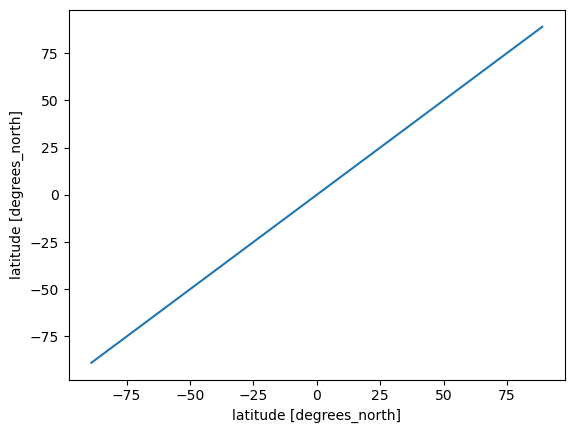

In [151]:
data.lat.plot()

In [152]:
data.lat[1] - data.lat[0]

<xarray.DataArray 'lat' ()>
array(-2.14285714)

## e)

In [162]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic',
     #resample_resolution=[0.2, 0.2]#,
     #filter={"bands" : ["sigma0_trip_fore"]},
     roi={"NSWE" : [90, ascat_lat -0, -180, 0]}
)

In [164]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 371e6549 started.
Customisation 371e6549 is running.
Customisation 371e6549 is running.
Customisation 371e6549 is running.
Customisation 371e6549 is running.
Customisation 371e6549 is running.
Customisation 371e6549 is running.
Customisation 371e6549 is successfully completed.
All customisations completed!


In [165]:
customisations

[<class 'eumdac.customisation.Customisation'>(371e6549)]

# Download

In [166]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_roi_northwest_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 371e6549
Dowloaded the output of the customisation 371e6549
	Finished dowloading the NetCDF output and deleted the customisation 371e6549


In [168]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_roi_northwest_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 14, lon: 84)
Coordinates:
  * lat                  (lat) float64 88.93 86.78 84.63 ... 65.3 63.16 61.01
  * lon                  (lon) float64 -178.9 -176.8 -174.6 ... -3.214 -1.071
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T221800Z
    stop_sensing_time:         20200122T000256.250000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  custom
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

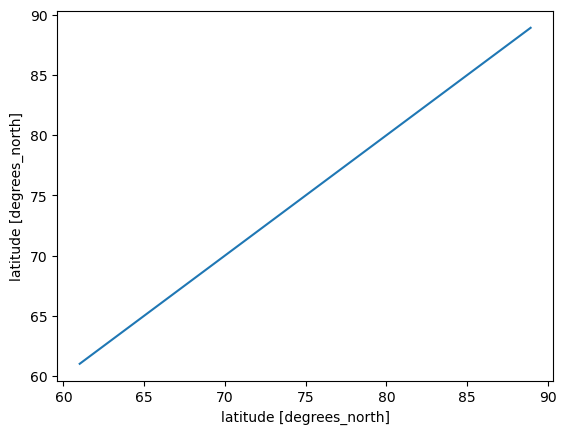

In [169]:
data.lat.plot()

In [170]:
data.lat[1] - data.lat[0]

<xarray.DataArray 'lat' ()>
array(-2.14759286)

## f)

In [184]:
ascat_lat + 30

89.9337

In [185]:
ascat_lat -30

29.9337

In [186]:
ascat_lon + 30

-9.473779999999998

In [187]:
ascat_lon - 30

-69.47378

In [176]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic',
     #resample_resolution=[0.2, 0.2]#,
     #filter={"bands" : ["sigma0_trip_fore"]},
     roi={"NSWE" : [ascat_lat + 30, ascat_lat -30, ascat_lon - 30, ascat_lon + 30]}
)

In [177]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 4b81d42a started.
Customisation 4b81d42a is queued.
Customisation 4b81d42a is running.
Customisation 4b81d42a is running.
Customisation 4b81d42a is running.
Customisation 4b81d42a is successfully completed.
All customisations completed!


In [178]:
customisations

[<class 'eumdac.customisation.Customisation'>(4b81d42a)]

# Download

In [179]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_geographic_roi_30_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 4b81d42a
Dowloaded the output of the customisation 4b81d42a
	Finished dowloading the NetCDF output and deleted the customisation 4b81d42a


In [180]:
data = xr.open_dataset('examples_low_resolution/netcdf4_geographic_roi_30_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (lat: 365, lon: 365)
Coordinates:
  * lat                  (lat) float64 89.85 89.69 89.52 ... 30.34 30.18 30.02
  * lon                  (lon) float64 -69.39 -69.23 -69.06 ... -9.72 -9.556
Data variables: (12/44)
    crs                  |S1 ...
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_kp_fore            (lat, lon) float32 ...
    f_kp_mid             (lat, lon) float32 ...
    ...                   ...
    f_tel_fore           (lat, lon) float32 ...
    f_tel_mid            (lat, lon) float32 ...
    f_tel_aft            (lat, lon) float32 ...
    f_v_fore             (lat, lon) float32 ...
    f_v_mid              (lat, lon) float32 ...
    f_v_aft              (lat, lon) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T234205.625000Z
    stop_sensing_time:         20200121T235856.250000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  custom
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

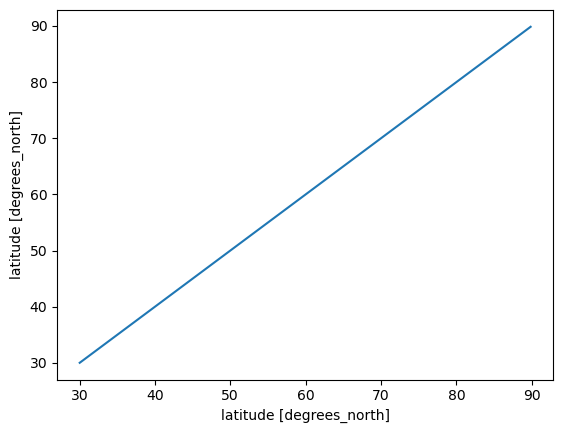

In [181]:
data.lat.plot()

In [182]:
data.lat[1] - data.lat[0]

<xarray.DataArray 'lat' ()>
array(-0.16438356)

In [183]:
data.lat[101] - data.lat[100]

<xarray.DataArray 'lat' ()>
array(-0.16438356)

## g)

In [71]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
)

In [72]:
customisations = []

print("Running customisations")

for product in products:
    # do not process products that are already downloaded
    if str(product) in dict_low_res.keys():     

        customisation = datatailor.new_customisation(product, chain)

        try:
            print(f"Customisation {customisation._id} started.")
        except eumdac.datatailor.DataTailorError as error:
            print(f"Error related to the Data Tailor: '{error.msg}'")
            break
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
            break
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
            break

        customisations.append(customisation)

        status = customisation.status
        sleep_time = 10 # seconds

        # Customisation Loop
        while status:
            # Get the status of the ongoing customisation
            status = customisation.status

            if "DONE" in status:
                print(f"Customisation {customisation._id} is successfully completed.")
                break
            elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
                print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
                print(customisation.logfile)
                break
            elif "QUEUED" in status:
                print(f"Customisation {customisation._id} is queued.")
            elif "RUNNING" in status:
                print(f"Customisation {customisation._id} is running.")
            time.sleep(sleep_time)
    break
        
print("All customisations completed!")

Running customisations
Customisation 68bd7f3c started.
Customisation 68bd7f3c is running.
Customisation 68bd7f3c is running.
Customisation 68bd7f3c is successfully completed.
All customisations completed!


In [73]:
customisations

[<class 'eumdac.customisation.Customisation'>(68bd7f3c)]

# Download

In [74]:
print("Downloading products")

for customisation in customisations:
    jobID = customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open('examples_low_resolution/netcdf4_' + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

	Starting to download the NetCDF output of the customisation 68bd7f3c
Dowloaded the output of the customisation 68bd7f3c
	Finished dowloading the NetCDF output and deleted the customisation 68bd7f3c


In [75]:
data = xr.open_dataset('examples_low_resolution/netcdf4_' + stream.name)
data

<xarray.Dataset>
Dimensions:              (y: 3360, x: 82)
Coordinates:
    latitude             (y, x) float32 ...
    longitude            (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/43)
    azi_angle_trip_fore  (y, x) float32 ...
    azi_angle_trip_mid   (y, x) float32 ...
    azi_angle_trip_aft   (y, x) float32 ...
    f_kp_fore            (y, x) float32 ...
    f_kp_mid             (y, x) float32 ...
    f_kp_aft             (y, x) float32 ...
    ...                   ...
    f_tel_fore           (y, x) float32 ...
    f_tel_mid            (y, x) float32 ...
    f_tel_aft            (y, x) float32 ...
    f_v_fore             (y, x) float32 ...
    f_v_mid              (y, x) float32 ...
    f_v_aft              (y, x) float32 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20200121T221800Z
    stop_sensing_time:         20200122T000258.125000Z
    EPCT_geospatial_lat_max:   0.0000
    EPCT_geospatial_lat_min:   0.0000
    EPCT_geospatial_lon_max:   0.0000
    ...                        ...
    EPCT_roi:                  null
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.2.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

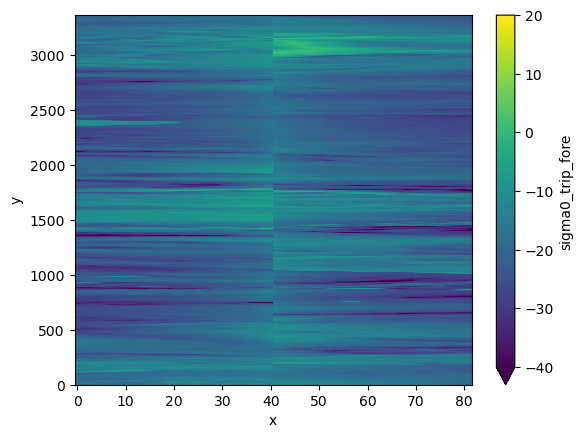

In [78]:
data['sigma0_trip_fore'].plot(vmax=20, vmin=-40)

In [76]:
data.latitude.shape

(3360, 82)

In [81]:
data.latitude[0, 0]

<xarray.DataArray 'latitude' ()>
array(73.459045, dtype=float32)
Coordinates:
    latitude   float32 ...
    longitude  float32 ...

In [82]:
data.latitude[1, 0]

<xarray.DataArray 'latitude' ()>
array(73.45793, dtype=float32)
Coordinates:
    latitude   float32 ...
    longitude  float32 ...

In [83]:
data.latitude[0, 1]

<xarray.DataArray 'latitude' ()>
array(73.571045, dtype=float32)
Coordinates:
    latitude   float32 ...
    longitude  float32 ...

In [84]:
data.latitude[1, 1]

<xarray.DataArray 'latitude' ()>
array(73.56992, dtype=float32)
Coordinates:
    latitude   float32 ...
    longitude  float32 ...

### The resolution of the raw images looks good!!!

### Reproject

In [ ]:
lats = data.latitude.values
lons = data.longitude.values
sigma0_trip_fore = data['sigma0_trip_fore']